# Smash Bros Ultimate Online Analysis
This notebook analyzes the data for all matches played on smash.gg where their characters or stage were recorded

In [1]:
import numpy as np
import pandas as pd
import plotnine
from plotnine import *

In [2]:
games_df = pd.read_csv('game_data.csv', index_col=0)
games_df.head()

/home/heil/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,char1,char2,stage,winner,entrant1,entrant2
0,Lucina,Ness,Pokémon Stadium 2,Ness,KG | Jegerlilla,RES | Venom
1,Ness,Lucina,Smashville,Lucina,RES | Venom,KG | Jegerlilla
2,Ness,Lucina,Battlefield,Lucina,RES | Venom,KG | Jegerlilla
3,Banjo-Kazooie,Young Link,Final Destination,Young Link,RoA | Irish_Penguin,LazZzy
4,Banjo-Kazooie,Young Link,Final Destination,Young Link,RoA | Irish_Penguin,LazZzy


## Most Popular Character/Stage
To better understand the data, the first step is to count the frequencies of each character and stage

In [3]:
games_df['stage'].value_counts()

Pokémon Stadium 2       342053
Final Destination       158605
Town and City           156874
Smashville              152235
Battlefield             145464
Kalos Pokémon League     84599
Yoshi's Story            36172
Lylat Cruise             22180
Yoshi's Island           12110
Pokémon Stadium           5006
Unova Pokémon League      2919
Castle Siege              1563
WarioWare, Inc.            248
Frigate Orpheon             75
Skyloft                     55
Magicant                    23
Mario Circuit               12
Name: stage, dtype: int64

### Stage Results:
Unsurprisingly, the top five stages are the five starting stages in modern rulesets. Other well-represented stages are stages [that were legal in the past.](https://smash.gg/tournament/ultimate-naifu-wars-1/details)

In [4]:
char_totals = games_df['char1'].value_counts() + games_df['char2'].value_counts()
sorted_totals = char_totals.sort_values(ascending=False)
for count, char in zip(sorted_totals, sorted_totals.index):
    print('{}\t\t\t{}'.format(char, count))

Joker			76216
Wolf			71543
Cloud			70066
Bowser			69585
Ness			69344
Pokemon Trainer			68667
Palutena			68432
Inkling			65275
Snake			63550
Yoshi			57508
R.O.B.			53458
Lucina			48352
Mario			48319
Donkey Kong			44059
Link			43949
Luigi			42325
Pikachu			41988
Sonic			40572
Zelda			40133
Ganondorf			39726
Roy			36174
Mr. Game and Watch			34255
Young Link			33942
King Dedede			33650
Ike			33548
Pac-Man			32941
Jigglypuff			32758
Greninja			32060
Banjo-Kazooie			31411
Captain Falcon			31241
Samus			30888
Lucas			30703
King K. Rool			30230
Zero Suit Samus			29531
Hero			27803
Terry			27622
Little Mac			27516
Wii Fit Trainer			26179
Chrom			25592
Fox			23095
Kirby			22821
Shulk			22412
Toon Link			22233
Piranha Plant			22113
Pichu			22056
Ridley			21781
Peach			21086
Bowser Jr.			20678
Mega Man			19837
Robin			19687
Ken			19408
Richter			17543
Bayonetta			17375
Wario			16787
Incineroar			16265
Falco			16101
Byleth			15610
Isabelle			15541
Dr. Mario			15499
Villager			14910
Diddy Kong			144

### Character Results


In [5]:
char_to_index = {}

i = 0
for char in games_df['char1']:
    if char not in char_to_index:
        char_to_index[char] = i
        i += 1
print(len(char_to_index))

82


In [6]:
# format = winner: loser: count
wins_map = {}

for _, row in games_df.iterrows():
    char1 = row['char1']
    char2 = row['char2']
    
    char1_is_winner = row['char1'] == row['winner']
    
    if not char1_is_winner:
        char1, char2 = (char2, char1)
        
    if char1 not in wins_map:
        wins_map[char1] = {}
        wins_map[char1][char2] = 1
    elif char2 not in wins_map[char1]:
        wins_map[char1][char2] = 1
    else:
        wins_map[char1][char2] += 1

In [7]:
matchup_info = {'char1': [], 
                'char2': [],
                'win_rate': [],
                'games_played': []
               }
char_to_win_rate = {}
for char1 in wins_map:
    char_win_rates = []
    for char2 in wins_map[char1]:
        matchup_info['char1'].append(char1)
        matchup_info['char2'].append(char2)
        
        games_played = wins_map[char1][char2]
        try:
            games_played += wins_map[char2][char1]
        except KeyError:
            pass
        
        win_rate = wins_map[char1][char2] / games_played
        char_win_rates.append(win_rate)
        
        matchup_info['win_rate'].append(win_rate)
        matchup_info['games_played'].append(games_played)
    char_to_win_rate[char1] = sum(char_win_rates) / len(char_win_rates)
    
for key in matchup_info:
    print(key, len(matchup_info[key]))
matchup_df = pd.DataFrame.from_dict(matchup_info)
matchup_df

char1 6604
char2 6604
win_rate 6604
games_played 6604


,char1,char2,win_rate,games_played
0,Ness,Lucina,0.433500,1797
1,Ness,Banjo-Kazooie,0.540354,1016
2,Ness,Mario,0.494403,1608
3,Ness,Shulk,0.503086,648
4,Ness,Chrom,0.454654,838
...,...,...,...,...
6599,Random,Dark Samus,0.500000,2
6600,Random,Marth,0.400000,5
6601,Random,Ryu,1.000000,1
6602,Random,Dark Pit,1.000000,1


In [8]:
matchup_df['char1_overall_win_rate'] = matchup_df['char1'].apply(lambda x: char_to_win_rate.get(x))
matchup_df['char2_overall_win_rate'] = matchup_df['char2'].apply(lambda x: char_to_win_rate.get(x))
matchup_df = matchup_df.sort_values(['char1_overall_win_rate', 'char2_overall_win_rate'], ascending=True)
matchup_df = matchup_df.dropna()
matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate
3796,Ryu,Ryu,0.500000,56,0.462883,0.462883
3733,Ryu,Snake,0.504132,242,0.462883,0.464341
3766,Ryu,Ken,0.478571,140,0.462883,0.465180
3754,Ryu,R.O.B.,0.522013,159,0.462883,0.466129
3779,Ryu,Richter,0.506667,75,0.462883,0.466587
...,...,...,...,...,...,...
6558,Random,Roy,0.600000,5,0.591951,0.532418
6595,Random,Mewtwo,0.666667,3,0.591951,0.532699
6592,Random,Corrin,1.000000,1,0.591951,0.539746
6589,Random,Lucina,0.500000,2,0.591951,0.549391


In [9]:
# Force char1 and char2 to be categorical to keep plotnine from resorting them
sorted_chars = matchup_df['char1'].unique().tolist()
char1_cat = pd.Categorical(matchup_df['char1'], categories=sorted_chars)
matchup_df['char1_cat'] = char1_cat
char2_cat = pd.Categorical(matchup_df['char2'], categories=sorted_chars)
matchup_df['char2_cat'] = char2_cat
matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
3796,Ryu,Ryu,0.500000,56,0.462883,0.462883,Ryu,Ryu
3733,Ryu,Snake,0.504132,242,0.462883,0.464341,Ryu,Snake
3766,Ryu,Ken,0.478571,140,0.462883,0.465180,Ryu,Ken
3754,Ryu,R.O.B.,0.522013,159,0.462883,0.466129,Ryu,R.O.B.
3779,Ryu,Richter,0.506667,75,0.462883,0.466587,Ryu,Richter
...,...,...,...,...,...,...,...,...
6558,Random,Roy,0.600000,5,0.591951,0.532418,Random,Roy
6595,Random,Mewtwo,0.666667,3,0.591951,0.532699,Random,Mewtwo
6592,Random,Corrin,1.000000,1,0.591951,0.539746,Random,Corrin
6589,Random,Lucina,0.500000,2,0.591951,0.549391,Random,Lucina


## Matchup Analysis

In [72]:
clean_matchup_df = matchup_df[matchup_df['char1'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['char2'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['games_played'] > 10]

clean_matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
3796,Ryu,Ryu,0.500000,56,0.462883,0.462883,Ryu,Ryu
3733,Ryu,Snake,0.504132,242,0.462883,0.464341,Ryu,Snake
3766,Ryu,Ken,0.478571,140,0.462883,0.465180,Ryu,Ken
3754,Ryu,R.O.B.,0.522013,159,0.462883,0.466129,Ryu,R.O.B.
3779,Ryu,Richter,0.506667,75,0.462883,0.466587,Ryu,Richter
...,...,...,...,...,...,...,...,...
130,Lucina,Roy,0.500575,869,0.549391,0.532418,Lucina,Roy
159,Lucina,Mewtwo,0.528889,225,0.549391,0.532699,Lucina,Mewtwo
120,Lucina,Corrin,0.500000,236,0.549391,0.539746,Lucina,Corrin
149,Lucina,Falco,0.520101,398,0.549391,0.542874,Lucina,Falco


In [73]:
clean_matchup_df[clean_matchup_df['games_played'] > 50].sort_values('win_rate', ascending=False).head(10)

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
3233,Falco,Ice Climbers,0.661972,71,0.542874,0.478413,Falco,Ice Climbers
6474,Daisy,Pac-Man,0.661017,59,0.490850,0.488824,Daisy,Pac-Man
1436,Fox,Mii Gunner,0.659574,94,0.526541,0.487059,Fox,Mii Gunner
6196,Corrin,Mega Man,0.658537,82,0.539746,0.474928,Corrin,Mega Man
3199,Falco,Toon Link,0.655844,154,0.542874,0.508367,Falco,Toon Link
150,Lucina,Ryu,0.652174,115,0.549391,0.462883,Lucina,Ryu
4331,Pit,Bowser Jr.,0.652174,69,0.510901,0.472860,Pit,Bowser Jr.
6491,Daisy,Mega Man,0.650000,60,0.490850,0.474928,Daisy,Mega Man
2174,Pac-Man,Simon Belmont,0.649351,77,0.488824,0.471784,Pac-Man,Simon Belmont
6097,Rosalina,King Dedede,0.648352,91,0.510435,0.484601,Rosalina,King Dedede


In [66]:
clean_matchup_df[clean_matchup_df['games_played'] > 1000].sort_values('win_rate', ascending=False).head(10)

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
113,Lucina,Snake,0.587922,1126,0.549391,0.464341,Lucina,Snake
105,Lucina,Mario,0.585646,1045,0.549391,0.514612,Lucina,Mario
4146,Joker,Snake,0.585054,2422,0.531268,0.464341,Joker,Snake
90,Lucina,Pikachu,0.579670,1092,0.549391,0.510509,Lucina,Pikachu
341,Wolf,Zelda,0.574944,1341,0.513250,0.478032,Wolf,Zelda
3279,Pikachu,Snake,0.571310,1206,0.510509,0.464341,Pikachu,Snake
444,Pokemon Trainer,Luigi,0.568293,1230,0.509069,0.476764,Pokemon Trainer,Luigi
81,Lucina,Ness,0.566500,1797,0.549391,0.492927,Lucina,Ness
5690,Greninja,Snake,0.563353,1026,0.498233,0.464341,Greninja,Snake
2537,Link,Snake,0.563149,1156,0.508831,0.464341,Link,Snake


/home/heil/anaconda3/lib/python3.7/site-packages/plotnine/scales/scale.py:91: PlotnineWarning: scale_fill_gradient2 could not recognise parameter `med`
  warn(msg.format(self.__class__.__name__, k), PlotnineWarning)


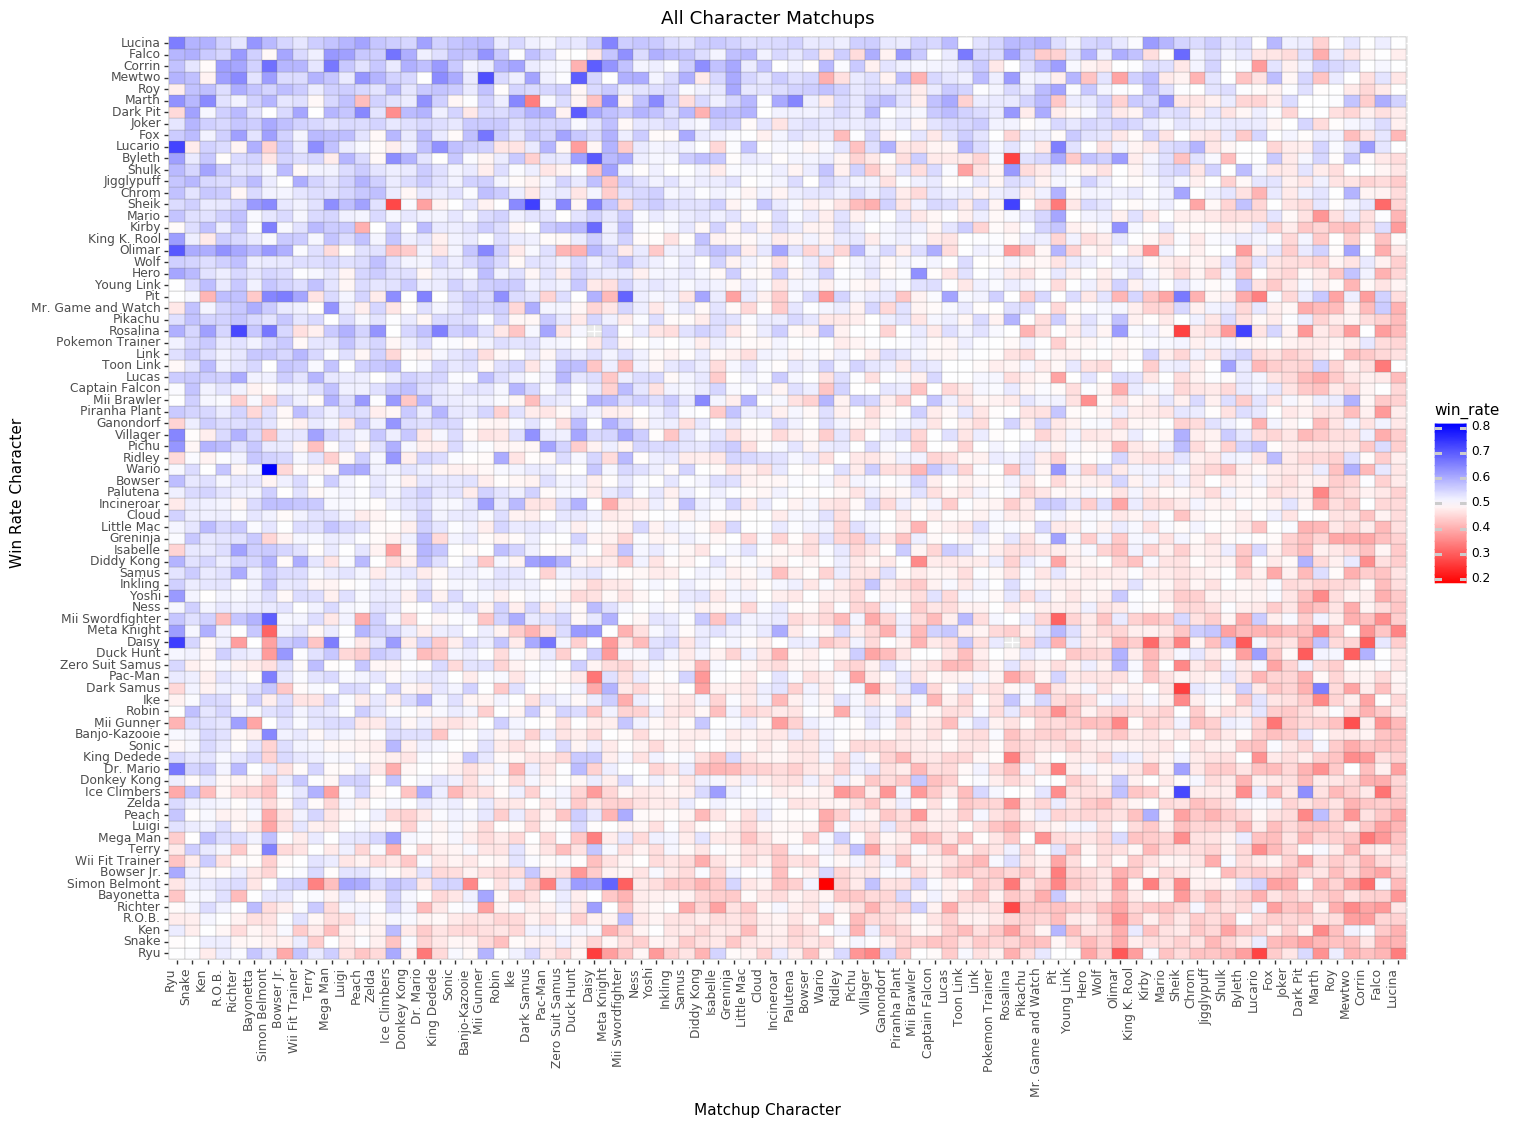

<ggplot: (8751617177673)>

In [67]:
plotnine.options.figure_size = (16, 12)
plot = ggplot(clean_matchup_df, aes(x='char2_cat', y='char1_cat', fill='win_rate')) 
plot += geom_tile(color='grey')
plot = plot + theme(axis_text_x=element_text(rotation=90, hjust=1))
plot += xlab('Matchup Character')
plot += ylab('Win Rate Character')
plot += ggtitle('All Character Matchups')
plot += scale_fill_gradient2(
  low = "#ff0000",
  med = "#ffffff",
  high = "#0000ff",
  midpoint = .5
)
plot

In [68]:
clean_matchup_df = matchup_df[matchup_df['char1'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['char2'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['games_played'] > 50]

clean_matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
3796,Ryu,Ryu,0.500000,56,0.462883,0.462883,Ryu,Ryu
3733,Ryu,Snake,0.504132,242,0.462883,0.464341,Ryu,Snake
3766,Ryu,Ken,0.478571,140,0.462883,0.465180,Ryu,Ken
3754,Ryu,R.O.B.,0.522013,159,0.462883,0.466129,Ryu,R.O.B.
3779,Ryu,Richter,0.506667,75,0.462883,0.466587,Ryu,Richter
...,...,...,...,...,...,...,...,...
130,Lucina,Roy,0.500575,869,0.549391,0.532418,Lucina,Roy
159,Lucina,Mewtwo,0.528889,225,0.549391,0.532699,Lucina,Mewtwo
120,Lucina,Corrin,0.500000,236,0.549391,0.539746,Lucina,Corrin
149,Lucina,Falco,0.520101,398,0.549391,0.542874,Lucina,Falco


/home/heil/anaconda3/lib/python3.7/site-packages/plotnine/scales/scale.py:91: PlotnineWarning: scale_fill_gradient2 could not recognise parameter `med`
  warn(msg.format(self.__class__.__name__, k), PlotnineWarning)


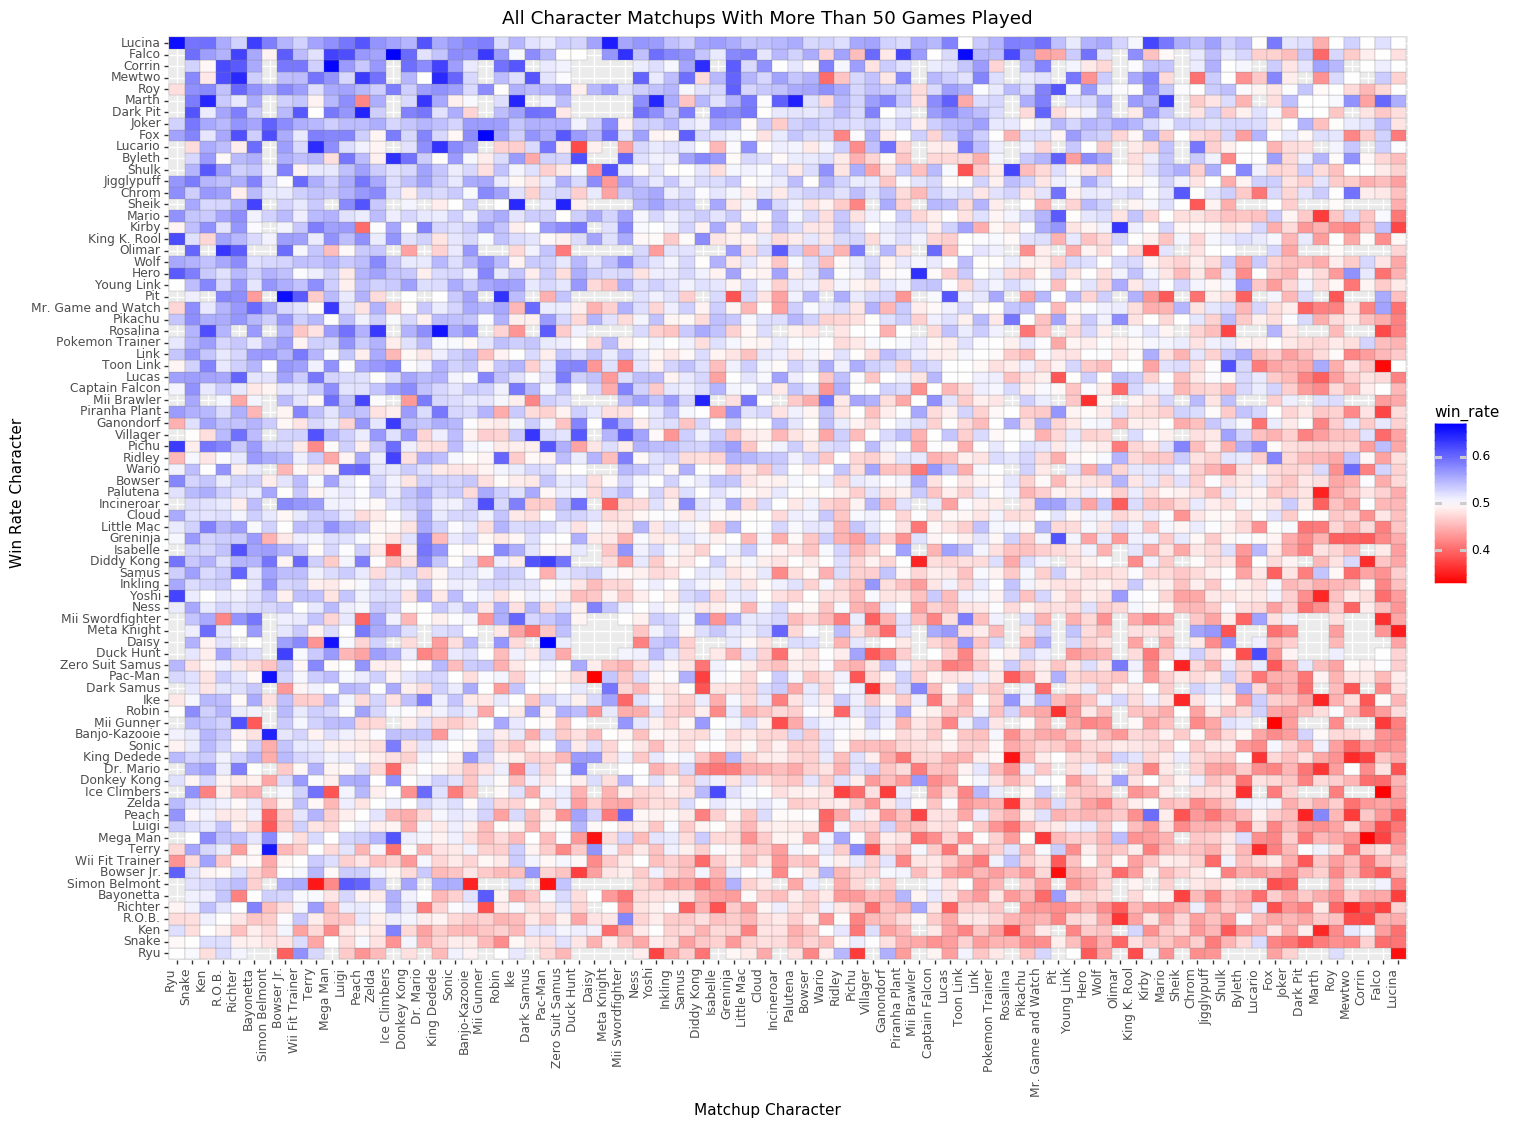

<ggplot: (8751619217853)>

In [69]:
plotnine.options.figure_size = (16, 12)
plot = ggplot(clean_matchup_df, aes(x='char2_cat', y='char1_cat', fill='win_rate')) 
plot += geom_tile(color='grey')
plot = plot + theme(axis_text_x=element_text(rotation=90, hjust=1))
plot += xlab('Matchup Character')
plot += ylab('Win Rate Character')
plot += ggtitle('All Character Matchups With More Than 50 Games Played')
plot += scale_fill_gradient2(
  low = "#ff0000",
  med = "#ffffff",
  high = "#0000ff",
  midpoint = .5
)
plot

In [44]:
matchup_df[matchup_df['char1'] == 'Bowser'].sort_values('win_rate')

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
1498,Bowser,Roy,0.443086,1063,0.503499,0.532418,Bowser,Roy
1492,Bowser,Falco,0.447412,599,0.503499,0.542874,Bowser,Falco
1534,Bowser,Mewtwo,0.450980,255,0.503499,0.532699,Bowser,Mewtwo
1517,Bowser,Pit,0.455959,193,0.503499,0.510901,Bowser,Pit
1461,Bowser,Joker,0.462782,2351,0.503499,0.531268,Bowser,Joker
...,...,...,...,...,...,...,...,...
1536,Bowser,Olimar,0.547619,168,0.503499,0.513770,Bowser,Olimar
1531,Bowser,Mii Brawler,0.552124,259,0.503499,0.507550,Bowser,Mii Brawler
1505,Bowser,Mega Man,0.557726,563,0.503499,0.474928,Bowser,Mega Man
1537,Bowser,Random,0.562500,16,0.503499,0.591951,Bowser,Random


## Stage Analysis

In [17]:
stages_df = games_df.dropna()

In [18]:
stages_df.head()

,char1,char2,stage,winner,entrant1,entrant2
0,Lucina,Ness,Pokémon Stadium 2,Ness,KG | Jegerlilla,RES | Venom
1,Ness,Lucina,Smashville,Lucina,RES | Venom,KG | Jegerlilla
2,Ness,Lucina,Battlefield,Lucina,RES | Venom,KG | Jegerlilla
3,Banjo-Kazooie,Young Link,Final Destination,Young Link,RoA | Irish_Penguin,LazZzy
4,Banjo-Kazooie,Young Link,Final Destination,Young Link,RoA | Irish_Penguin,LazZzy


In [19]:
legal_stages = set(['Pokémon Stadium 2', 'Smashville', 'Battlefield', 'Final Destination',
                    'Kalos Pokémon League', 'Lylat Cruise', 'Town and City',
                    "Yoshi's Story"
                   ])

stage_wins = {}
stage_losses = {}

for _, row in stages_df.iterrows():
    char1 = row['char1']
    char2 = row['char2']
    winner = row['winner']
    stage = row['stage']
    
    if stage not in legal_stages:
        continue
    
    if char1 == char2: 
        continue
        
    if char1 != winner:
        char1, char2 = (char2, char1)
    
    if stage in stage_wins:
        if char1 in stage_wins[stage]:
            stage_wins[stage][char1] += 1
        else:
            stage_wins[stage][char1] = 1
    else:
        stage_wins[stage] = {}
        stage_wins[stage][char1] = 1
            
    if stage in stage_losses:
        if char2 in stage_losses[stage]:
            stage_losses[stage][char2] += 1
        else:
            stage_losses[stage][char2] = 1
    else:
        stage_losses[stage] = {}
        stage_losses[stage][char2] = 1

In [23]:
winrate_info = {'char': [], 'stage': [], 'character_winrate': [],
                    'stage_winrate': [], 'games_played': []}

for stage in stage_wins:
    for char in stage_wins[stage]:
        if stage not in stage_losses or char not in stage_losses[stage]:
            continue
        wins = stage_wins[stage][char]
        losses = stage_losses[stage][char]
        win_rate = wins / (wins + losses)
        
        winrate_info['char'].append(char)
        winrate_info['stage'].append(stage)
        winrate_info['stage_winrate'].append(win_rate)
        winrate_info['games_played'].append(wins + losses)
        winrate_info['character_winrate'].append(char_to_win_rate[char])

In [24]:
winrate_df = pd.DataFrame.from_dict(winrate_info)

In [25]:
winrate_df['stage_benefit'] = winrate_df['stage_winrate'] - winrate_df['character_winrate'] 
winrate_df

,char,stage,character_winrate,stage_winrate,games_played,stage_benefit
0,Ness,Pokémon Stadium 2,0.492927,0.504489,19713,0.011563
1,Wolf,Pokémon Stadium 2,0.513250,0.549843,22661,0.036593
2,Snake,Pokémon Stadium 2,0.464341,0.523707,19973,0.059366
3,Mr. Game and Watch,Pokémon Stadium 2,0.510810,0.461193,8916,-0.049616
4,Kirby,Pokémon Stadium 2,0.514153,0.485116,6349,-0.029037
...,...,...,...,...,...,...
643,Pit,Yoshi's Story,0.510901,0.452736,201,-0.058165
644,Ryu,Yoshi's Story,0.462883,0.369318,176,-0.093564
645,Mii Gunner,Yoshi's Story,0.487059,0.245059,253,-0.241999
646,Random,Yoshi's Story,0.591951,0.571429,14,-0.020523


/home/heil/anaconda3/lib/python3.7/site-packages/plotnine/scales/scale.py:91: PlotnineWarning: scale_fill_gradient2 could not recognise parameter `med`
  warn(msg.format(self.__class__.__name__, k), PlotnineWarning)


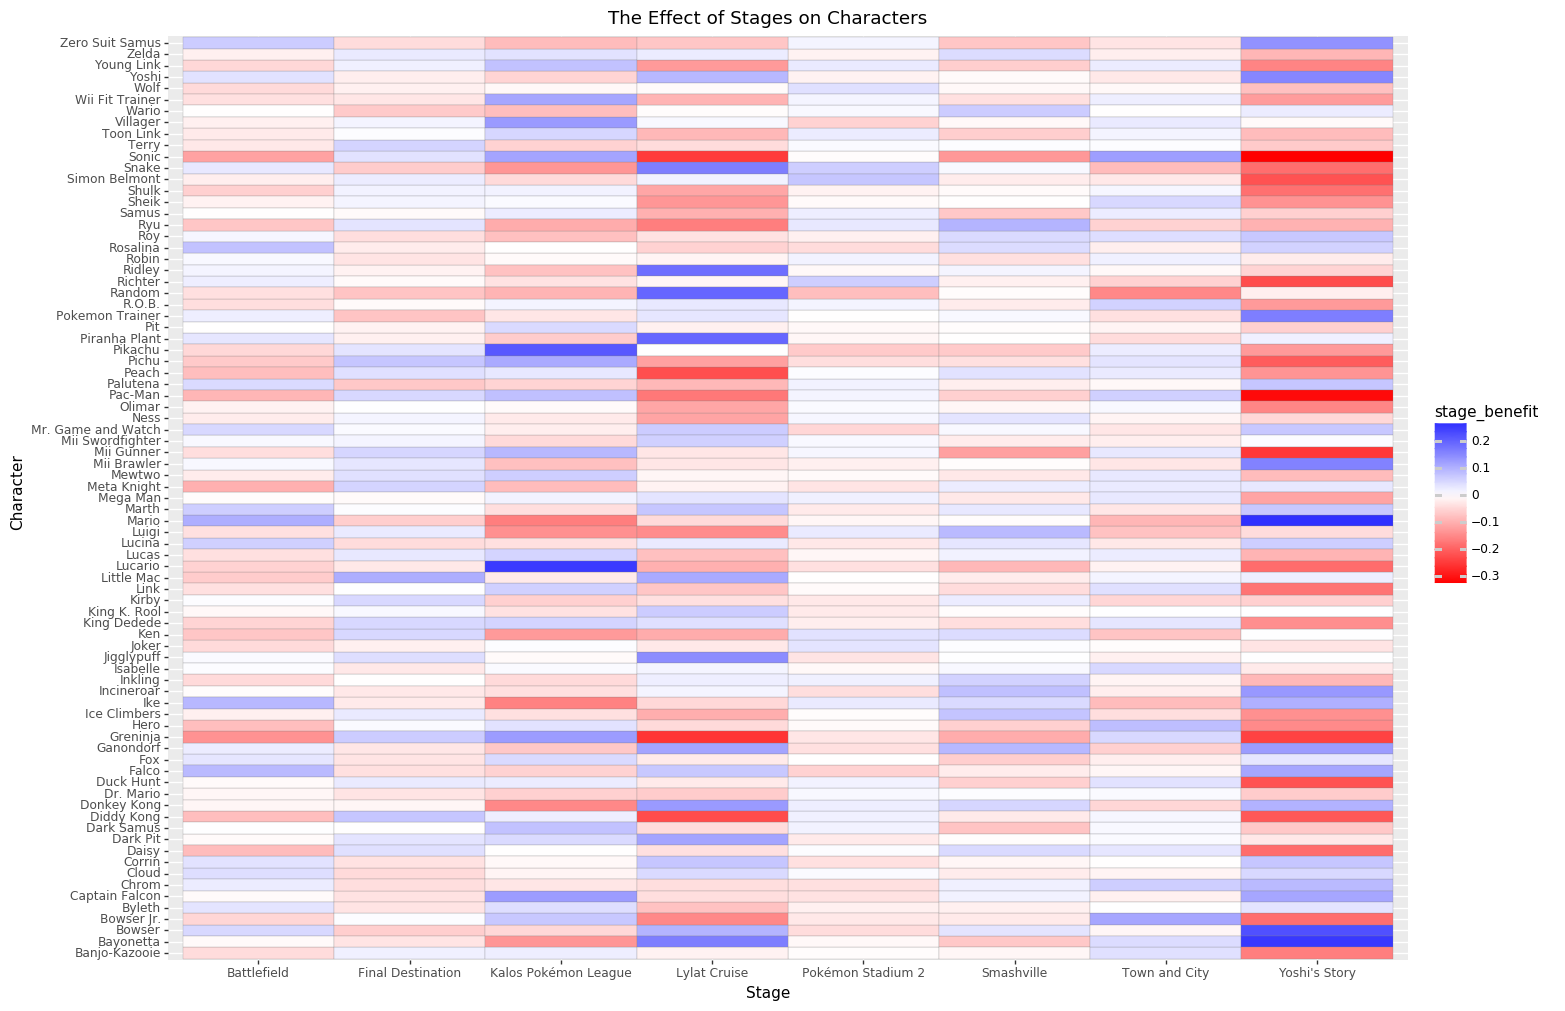

<ggplot: (8751619308541)>

In [63]:
plot =ggplot(winrate_df, aes(x='stage', y='char', fill='stage_benefit')) + geom_tile(color='grey') 
plot += xlab('Stage')
plot += ylab('Character')
plot += ggtitle('The Effect of Stages on Characters')
plot += scale_fill_gradient2(
  low = "#ff0000",
  med = "#ffffff",
  high = "#0000ff",
)
plot

In [ ]:
winrate_df[winrate_df['char'] == 'Bowser']

In [ ]:
winrate_df.sort_values('stage_benefit')

In [ ]:
winrate_df = winrate_df.sort_values(['stage', 'char'])
winrate_df.to_csv('stage_stats.csv', index=False, float_format='%.3f')

In [22]:
wolf_df = matchup_df[matchup_df['char1'] == 'Wolf']
wolf_df[wolf_df['char2'] == 'Jigglypuff']

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
360,Wolf,Jigglypuff,0.476923,975,0.51325,0.516648,Wolf,Jigglypuff
